In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.getcwd()

'/home/adwai/BTP/genre'

In [2]:
import pickle
import torch
import utils
import data.utils as dutils
import matplotlib.pyplot as plt
import numpy as np

import recourse.utils as rutils
from sklearn.neighbors import LocalOutlierFactor
from recourse.genre import GenRe
from recourse.genre import FlexibleGenRe

In [3]:
import models.flexible_binnedpm as bpm

In [4]:
exp_config = utils.load_config('results/exp1_config.yaml')
IMP_SAMP_FLAG = True
BEST_K = 20

In [5]:
def get_cost(src_X, tgt_X, immutable_mask, cost_weights=[0.5, 0.5], p=2):
    cost_weights = torch.tensor(cost_weights, device=src_X.device, dtype=src_X.dtype)
    cost_weights /= torch.sum(cost_weights)
    diff = (src_X - tgt_X).abs()  # [N, D]
    D = ((diff ** p) * cost_weights).sum(dim=-1) ** (1 / p)  # [N]
    cost = torch.mean(D)
    return cost

def get_LOF(tgt_X, ann_clf, gamma=0.7):
    pred = ((ann_clf(tgt_X)>gamma)*1.0)
    LOF = torch.mean(pred)
    return LOF

def get_val(tgt_X, ann_clf):
    pred = ((ann_clf(tgt_X)>0.5)*1.0)
    val = torch.mean(pred)
    return val

def get_score(src_X, tgt_X, immutable_mask, ann_clf, cost_weights=[0.5, 0.5], lambda_=50.0, p=2, gamma=0.7):
    cost = get_cost(src_X, tgt_X, immutable_mask, cost_weights=cost_weights, p=p)
    LOF = get_LOF(tgt_X, ann_clf, gamma=gamma)
    val = get_val(tgt_X, ann_clf)
    print("cost: ", round(cost.item(), 3))
    print("val: ", round(val.item(), 3))
    print("LOF: ", round(LOF.item(), 3))
    score = val + LOF - cost/p
    print("Score: ", round(score.item(), 3))
    return score

In [6]:
def get_true_probabs(src_X, tgt_X, immutable_mask, ann_clf, cost_weights=[0.5, 0.5], lambda_=50.0, p=2):
    cost_weights = torch.tensor(cost_weights, device=src_X.device, dtype=src_X.dtype)
    cost_weights /= torch.sum(cost_weights)
    diff = (src_X - tgt_X).abs()  # [N, D]
    D = ((diff ** p) * cost_weights).sum(dim=-1) ** (1 / p)  # [N]
    expD = torch.exp(- lambda_ * D)
    preds = ann_clf(tgt_X).reshape(-1)
    vals = ((preds>0.5)*1.0)
    probs = expD * preds * vals
    norm_probs = probs / torch.sum(probs)
    # print("src_X: ", src_X)
    # print("probs: ", norm_probs)
    # print("tgt_X: ", tgt_X)
    return norm_probs

def perform_importance_sampling(tgt_X, true_probs, num_samples=None):
    N = tgt_X.shape[0]
    if num_samples is None:
        num_samples = N
    true_probs = true_probs / true_probs.sum()

    idx = torch.multinomial(true_probs, num_samples=num_samples, replacement=True)
    resampled_X = tgt_X[idx]
    # print("resampled_X: ", resampled_X)
    return resampled_X

In [7]:
# cost_weights = [[1.0, 0.0]]
# cost_weights_str = f"{cost_weights[0]:.1f}_{cost_weights[1]:.1f}"

----------------------------- Executing for Dataset moons -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/moons/ann_rf_tt_mm_8_6_8
cost:  0.178
val:  1.0
LOF:  1.0
Score:  1.822
----------------------------- Executing for Dataset moons -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/moons/ann_rf_tt_mm_8_6_8
cost:  0.187
val:  1.0
LOF:  1.0
Score:  1.813
----------------------------- Executing for Dataset moons -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/moons/ann_rf_tt_mm_8_6_8
cost:  0.199
val:  1.0
LOF:  1.0
Score:  1.801
----------------------------- Executing for Dataset moons -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/moons/ann_rf_tt_mm_8_6_8
cost:  0.211
val:  1.0
LOF:  1.0
Score:  1.789
----------------------------- Executing for Dataset moon

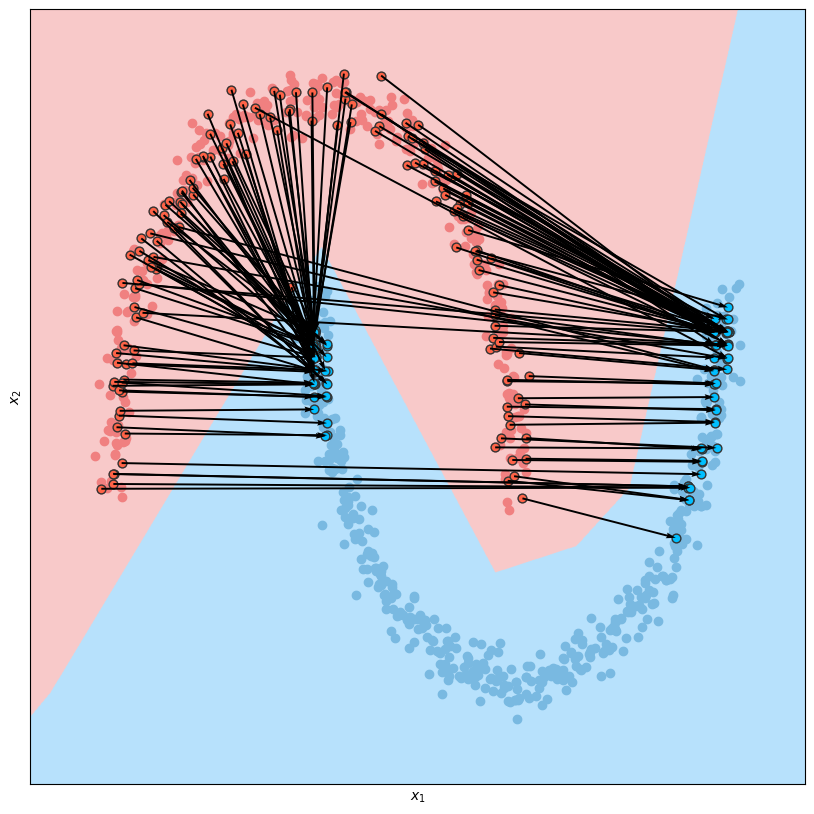

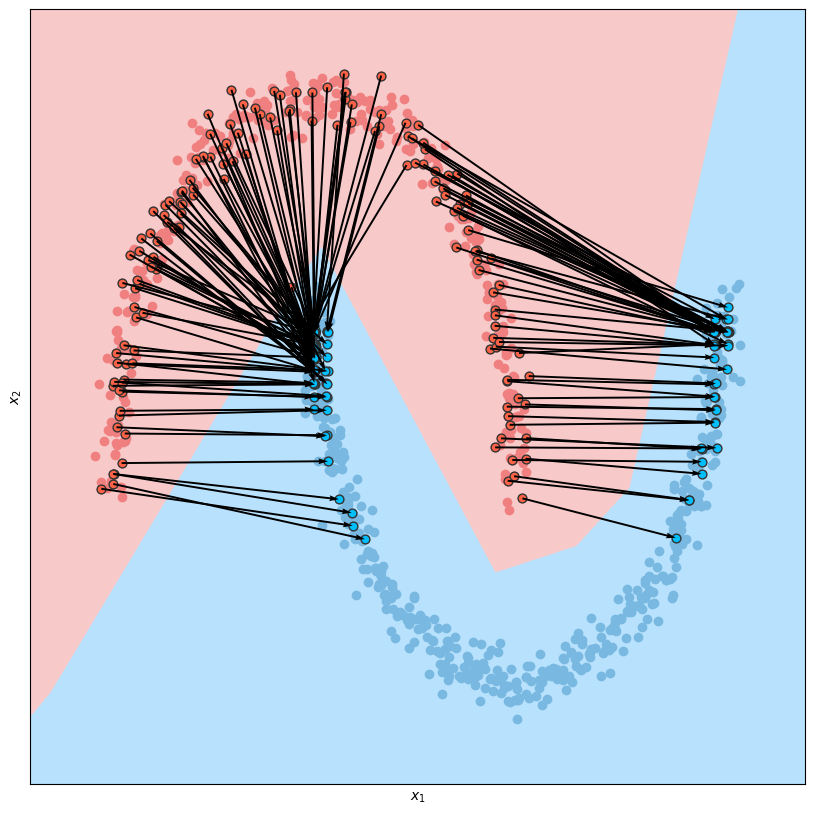

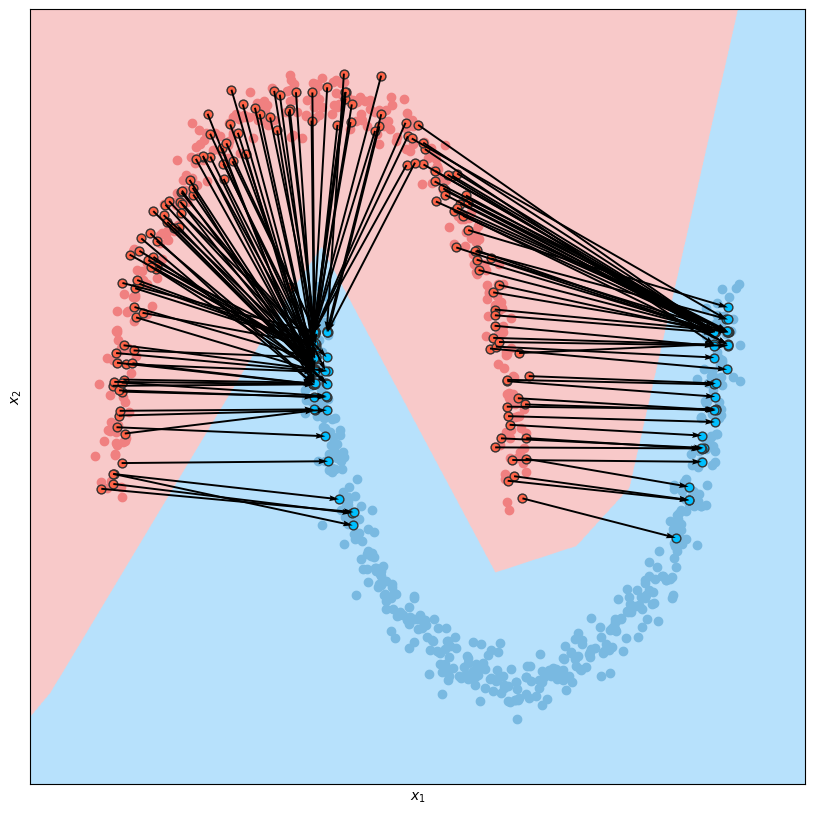

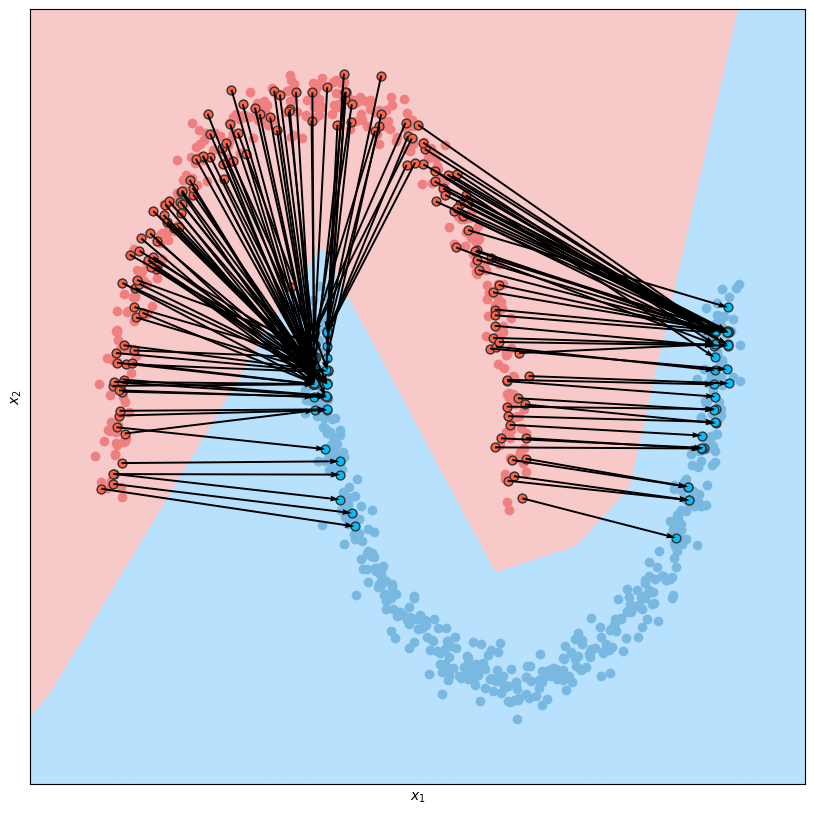

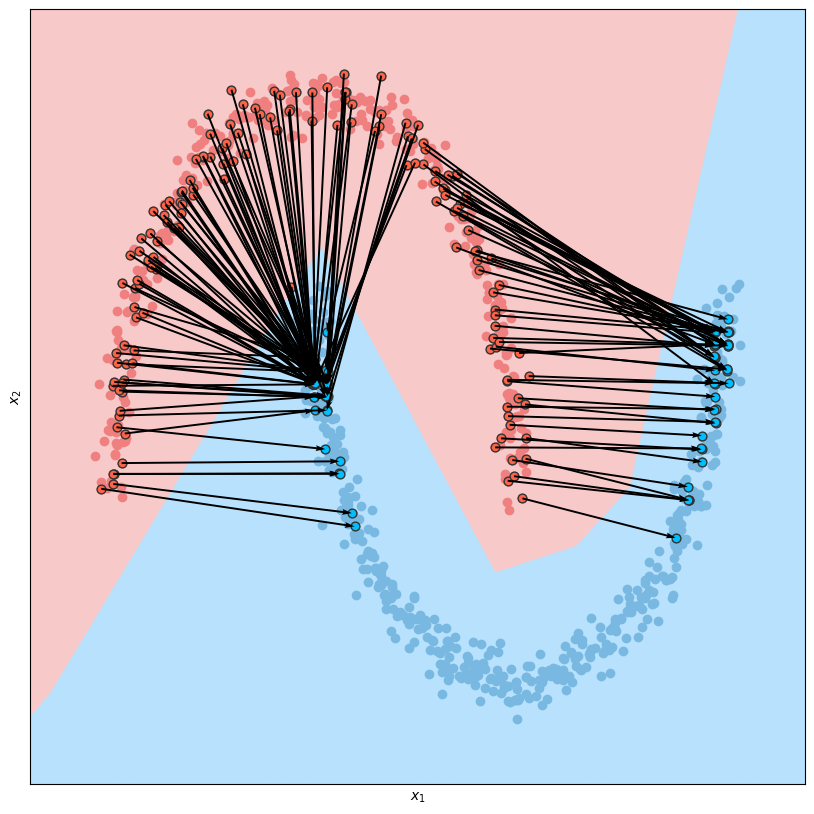

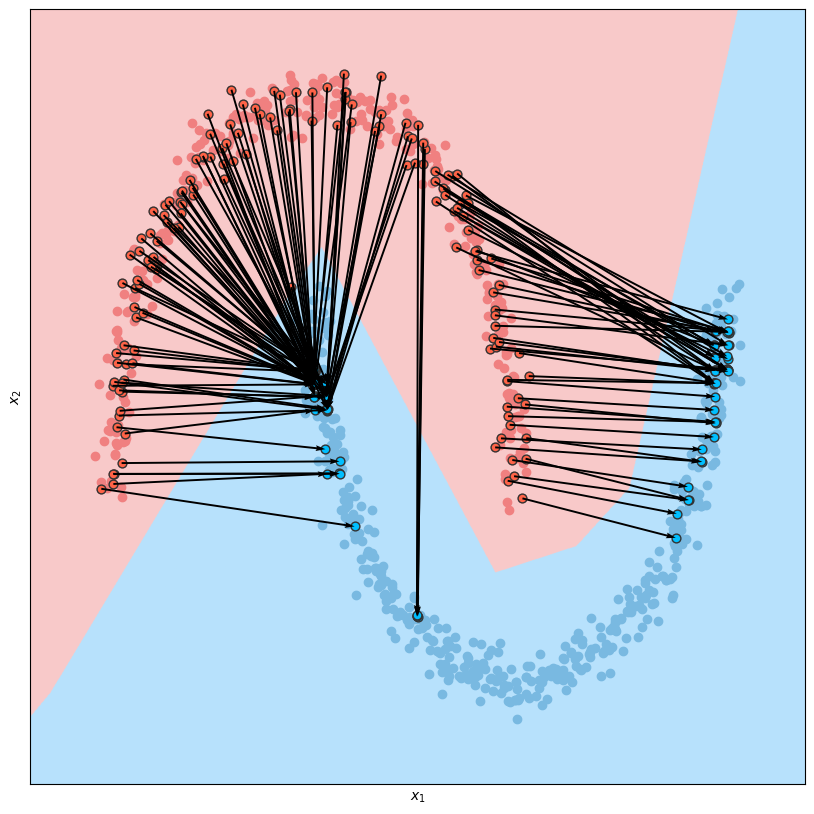

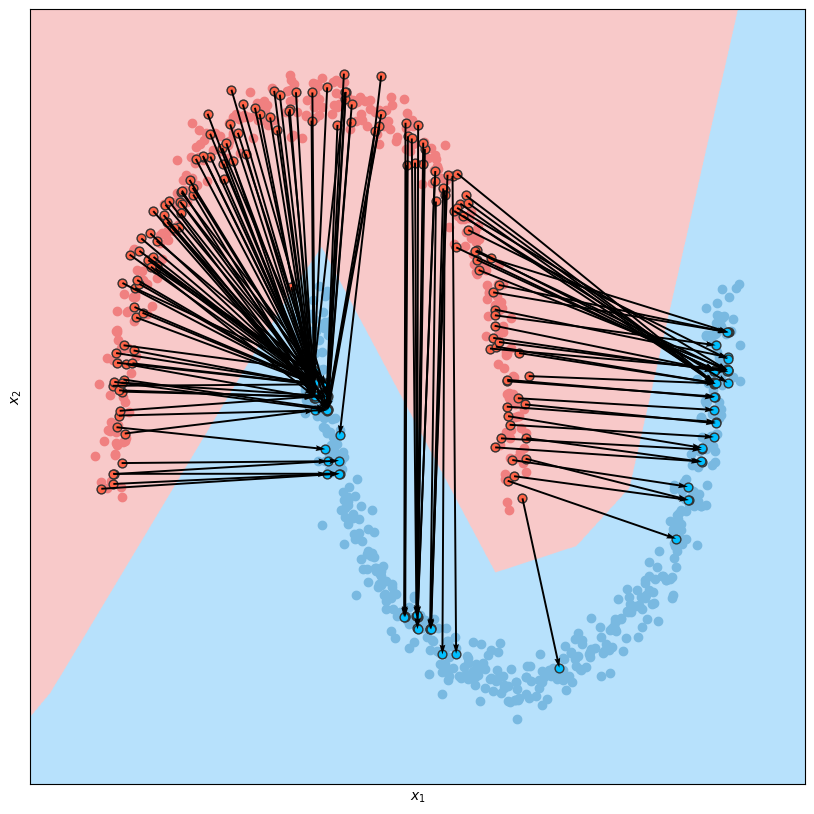

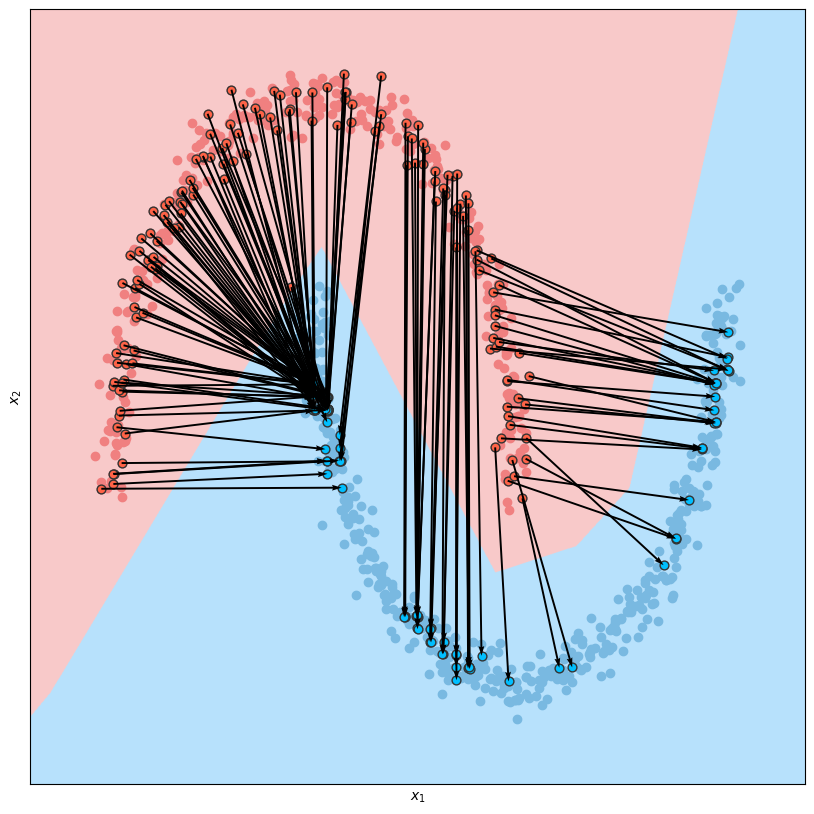

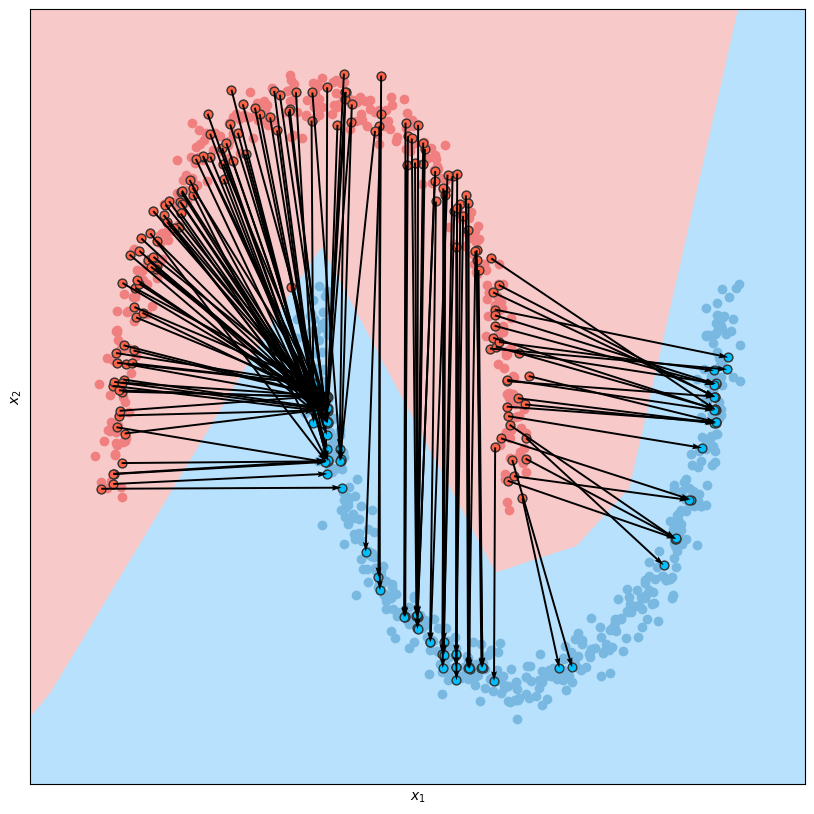

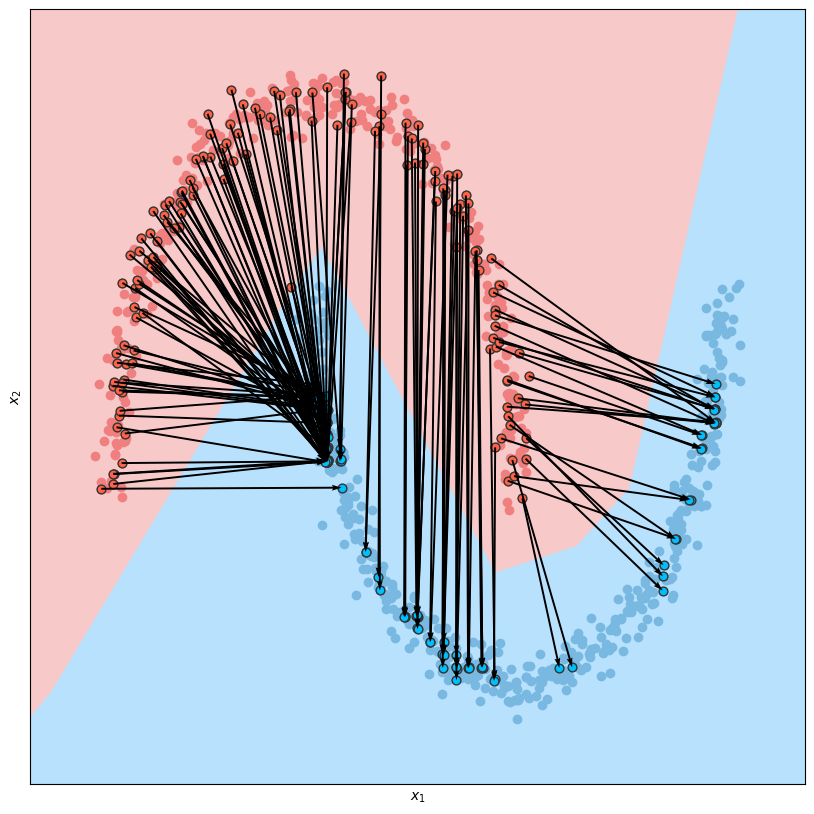

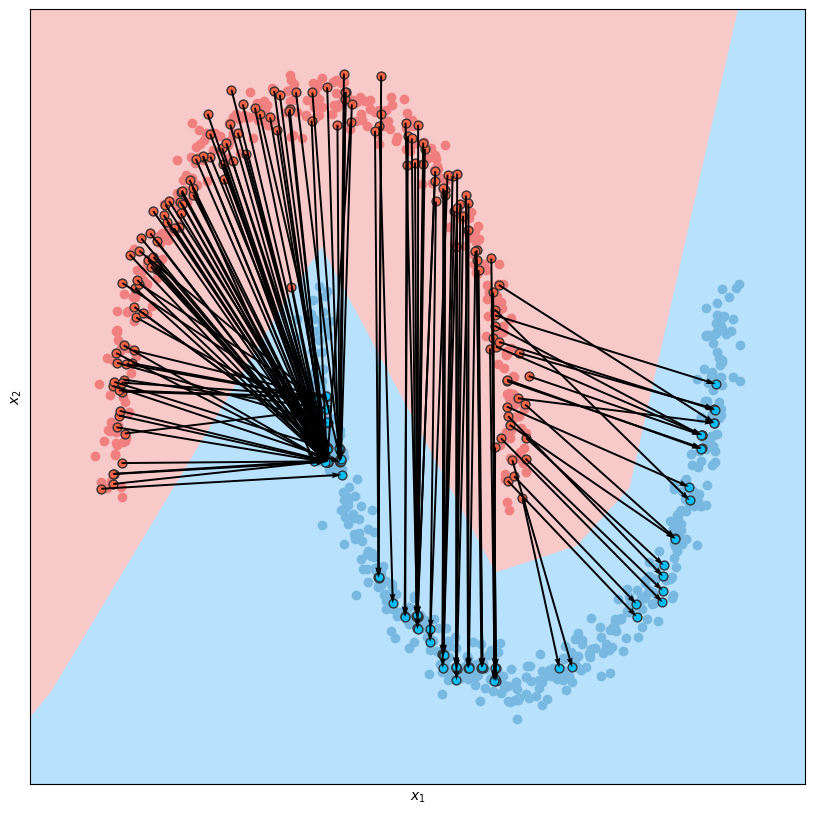

In [8]:
for DATASET_STR in ['moons']: #['squares']: #['circles']: #['squares']:  #['compas-all','heloc', 'adult-all']:
    for train_lambda in [50.0]: #[75.0]: #[10.0]: #[5.0]:
        all_weights = []
        all_scores = []
        for weight_1 in np.arange(0, 1.1, 0.1):
            cost_weights = [float(weight_1), 1.0-float(weight_1)]
            cost_weights_str = f"{cost_weights[0]:.1f}_{cost_weights[1]:.1f}"
            print(f"----------------------------- Executing for Dataset {DATASET_STR} -----------------------------")
            YSTAR = 1.0
            DEVICE = 'cpu' #'cuda:0'
            TRAIN_P = 1
            SEED = 42
    
            utils.set_seed(SEED)
    
            # load dataset
            train_y,train_X,test_y,test_X, cat_mask, immutable_mask = dutils.load_dataset(DATASET_STR, ret_tensor=True, min_max=True, ret_masks=True)
            INPUT_SHAPE = train_X.shape[1]
    
            LABEL_PATH =  utils.get_rf_folder(DATASET_STR,True,True)
            train_y,train_X,test_y,test_X = dutils.load_dataset(DATASET_STR, cust_labels_path=LABEL_PATH, ret_tensor=True, min_max=True)
            INPUT_SHAPE = train_X.shape[1]
            ann_clf, ann_folder = utils.load_ann(INPUT_SHAPE=INPUT_SHAPE,DATASET_STR=DATASET_STR, 
                                                    LABEL_SRC='rf',**exp_config['common'],**exp_config['ann'][DATASET_STR])
    
            pair_model = bpm.PairedTransformerBinnedWeighted(
                                                            n_bins=50,                # Keep as is — fine resolution for continuous features
                                                            num_inputs=2,             # Since your data is 2D
                                                            num_labels=1,             # Binary classification
                                                            num_encoder_layers=2,     # Only 2 encoder layers are sufficient
                                                            num_decoder_layers=2,     # 2 decoder layers for similar capacity
                                                            emb_size=16,              # Smaller embedding (reduces overfitting)
                                                            nhead=2,                  # 2 heads => each head gets 8-dim subspace
                                                            dim_feedforward=64,       # Slightly higher than emb_size, stable transformer FF
                                                            dropout=0.1,               # Regularization, fine for small data
                                                        ).to(DEVICE)
    
            # PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'
            # PM_STATE_PATH  = f'./saved_models/flexible_genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'
            PM_STATE_PATH  = f'./saved_models/flexible_genre_2/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'
    
            state = torch.load(PM_STATE_PATH, map_location='cpu')
            pair_model.load_state_dict(state["state_dict"])
            pair_model = pair_model.to(DEVICE)
            pair_model.eval()

            loss_log = {k:state[k] for k in ('train','val','test')}
            
            fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 20))
            # fig.set_size_inches(10, 20)
            # utils.plot_curves(ax[0],loss_log)
    
            # best_epoch = state['epoch']
            # ax[0].set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
            
            ann_clf = ann_clf.to(DEVICE)
    
            # # get negative instances
            xf_r = rutils.get_neg_inst(ann_clf,train_X,YSTAR,sample=150)
            xf_r = xf_r.to(DEVICE)
            # wf random weights between 0 and 1 , with same shape as xf_r
            # wf weights 1,0 for first feature and 0 for rest of the features

            # torch.save(xf_r, f'{DATASET_STR}_test.pth')
            
            rec_module = FlexibleGenRe(pair_model=pair_model, temp=10, sigma=0.001, best_k=BEST_K, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
            sample_xcf = rec_module(xf_r, cost_weights)
            if IMP_SAMP_FLAG:
                samples = rec_module.sample(xf_r, cost_weights)
                # print(sample_xcf.shape)
                # print(samples.shape)
        
                resampled_xcf_list = []
                try_i = 0
                for i in range(len(sample_xcf)):
                    src_X = xf_r[i].expand(len(samples[i]), -1)
                    # print(src_X.shape)
                    true_probs = get_true_probabs(src_X, samples[i], immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P)
                    # print("True probs: ", true_probs.shape)
                    new_sample = perform_importance_sampling(samples[i], true_probs, num_samples=1)
                    # print("New sample: ", new_sample[0].shape)
                    resampled_xcf_list.append(new_sample[0])
                
                sample_xcf = torch.stack(resampled_xcf_list)
            # print("resampled: ", resampled_xcf.shape)
            # imp_wts = get_true_probabs(xf_r, sample_xcf_approx, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P)
    
            final_score = get_score(xf_r, sample_xcf, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P, gamma=0.7)
            # adjusted_score = val + LOF - cost/(1 + (2*(weight_1 if weight_1 <= 0.5 else 1-weight_1))**(1))
            # print("Adj Score: ", adjusted_score)
            all_weights.append(cost_weights)
            all_scores.append(final_score.item())
            # all_adj_scores.append(adjusted_score.item())
            # all_costs.append(cost.item())
            
            # print(sample_xcf)
            utils.viz_clf(ax,ann_clf,train_X,train_y,hard=True)
            utils.scatter2d(ax,train_X,train_y,data_name='training data', s=20, show_axis_name=False)
            utils.plot_pairs(ax,xf_r,sample_xcf,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)
            if IMP_SAMP_FLAG:
                # PM_OUTDIR = f'./results/flexible_genre/{DATASET_STR}_gamma0.7'
                PM_OUTDIR = f'./results/flexible_genre_2/{DATASET_STR}_gamma0.7'
            else:
                PM_OUTDIR = f'./results/flexible_genre_non_imp/{DATASET_STR}_gamma0.7'
            os.makedirs(PM_OUTDIR, exist_ok=True)
            plt.savefig(f"{PM_OUTDIR}/plot_{train_lambda}_{cost_weights_str}.png")
            # plt.show()

[1.8218142986297607, 1.8126100301742554, 1.8014246225357056, 1.7886714935302734, 1.7753231525421143, 1.7661280632019043, 1.7642074823379517, 1.7786221504211426, 1.792493462562561, 1.8088295459747314, 1.83696711063385]


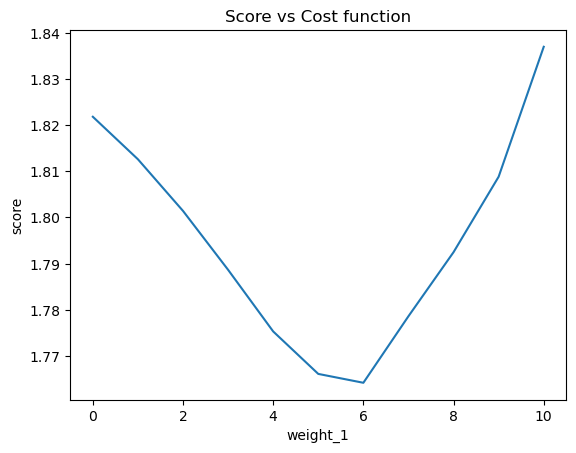

In [9]:
plt.plot(all_scores)
print(all_scores)
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function')
plt.savefig(f"{PM_OUTDIR}/plot_{train_lambda}_score_vs_cost.png")

In [10]:
squares_75 = [1.9879649877548218, 1.955613613128662, 1.916380763053894, 1.8847100734710693, 1.861577033996582, 1.848055362701416, 1.850612998008728, 1.8720426559448242, 1.8961784839630127, 1.9144960641860962, 1.9366545677185059]
circles_75 = [1.9169631004333496, 1.9077943563461304, 1.9045523405075073, 1.8969672918319702, 1.8978145122528076, 1.9140067100524902, 1.91950261592865, 1.9260503053665161, 1.9329360723495483, 1.9404164552688599, 1.9501633644104004]
circles_50 = [1.935959815979004, 1.921014666557312, 1.9073253870010376, 1.9082586765289307, 1.9060208797454834, 1.913170337677002, 1.916137456893921, 1.9214205741882324, 1.9283791780471802, 1.9348266124725342, 1.9435080289840698]
squares_50 = [1.9873194694519043, 1.9550023078918457, 1.9210325479507446, 1.8830705881118774, 1.8559128046035767, 1.8440765142440796, 1.849379062652588, 1.863128662109375, 1.8789921998977661, 1.8899136781692505, 1.910008192062378]
circles_75_old = [1.9330315589904785, 1.9238200187683105, 1.9131152629852295, 1.902999758720398, 1.889527678489685, 1.8764560222625732, 1.8885964155197144, 1.9064807891845703, 1.918625831604004, 1.932174563407898, 1.944899320602417]
squares_75_old = [1.9808284044265747, 1.9480232000350952, 1.9149260520935059, 1.8754643201828003, 1.7808079719543457, 1.6737223863601685, 1.781288981437683, 1.8769646883010864, 1.9135054349899292, 1.946479082107544, 1.979319453239441]
squares_50_non_imp = [1.948123812675476, 1.9170678853988647, 1.8886932134628296, 1.856802225112915, 1.8297512531280518, 1.8198105096817017, 1.8276381492614746, 1.8392915725708008, 1.8576210737228394, 1.870476484298706, 1.89345121383667]
circles_50_non_imp = [1.9230663776397705, 1.9148852825164795, 1.9094088077545166, 1.9040732383728027, 1.9009413719177246, 1.9026495218276978, 1.9062378406524658, 1.9108169078826904, 1.9166209697723389, 1.9221233129501343, 1.9315452575683594]
circles_75_non_imp = [1.8960258960723877, 1.8956453800201416, 1.8984029293060303, 1.8976593017578125, 1.9001548290252686, 1.9042185544967651, 1.909187912940979, 1.915468454360962, 1.9218889474868774, 1.9296590089797974, 1.9384649991989136]
squares_75_non_imp = [1.9677375555038452, 1.9321287870407104, 1.8999710083007812, 1.8691654205322266, 1.845894694328308, 1.8318439722061157, 1.8344637155532837, 1.8516757488250732, 1.8783528804779053, 1.9018266201019287, 1.92462956905365]
moons_50 = [1.8472779989242554, 1.8350509405136108, 1.8248989582061768, 1.8141549825668335, 1.8035637140274048, 1.7961713075637817, 1.7866514921188354, 1.7964097261428833, 1.8140718936920166, 1.8440256118774414, 1.866366982460022]
moons_50_non_imp = [1.842250108718872, 1.826059341430664, 1.8160480260849, 1.805423378944397, 1.7948464155197144, 1.788170337677002, 1.7796064615249634, 1.7836002111434937, 1.7985470294952393, 1.823008418083191, 1.8450080156326294]

squares_50_2 = [1.9814497232437134, 1.9487712383270264, 1.917783260345459, 1.8866243362426758, 1.8574838638305664, 1.8388793468475342, 1.8407810926437378, 1.855170488357544, 1.8789318799972534, 1.9104702472686768, 1.9447624683380127]
circles_50_2 = [1.937065601348877, 1.9230568408966064, 1.8895156383514404, 1.8720134496688843, 1.876112937927246, 1.8882430791854858, 1.9106597900390625, 1.9095711708068848, 1.9321672916412354, 1.9404160976409912, 1.9511706829071045]
moons_50_2 = [1.8218142986297607, 1.8126100301742554, 1.8014246225357056, 1.7886714935302734, 1.7753231525421143, 1.7661280632019043, 1.7642074823379517, 1.7786221504211426, 1.792493462562561, 1.8088295459747314, 1.83696711063385]



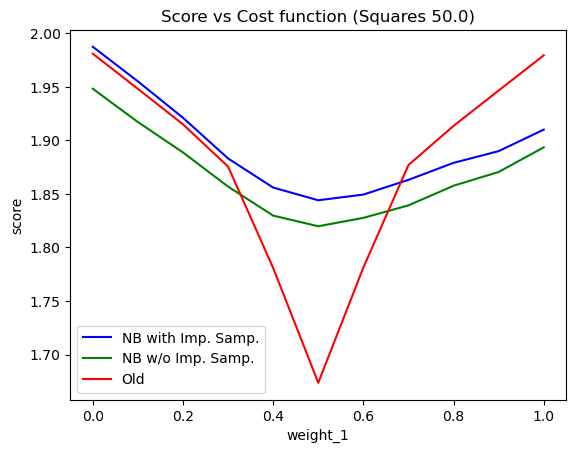

In [22]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, squares_50, color='blue')
plt.plot(wt_list, squares_50_non_imp, color='green')
plt.plot(wt_list, squares_75_old, color='red')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Squares 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB w/o Imp. Samp.', 'Old'])
plt.savefig('./results/squares_comparison_50_75.png')

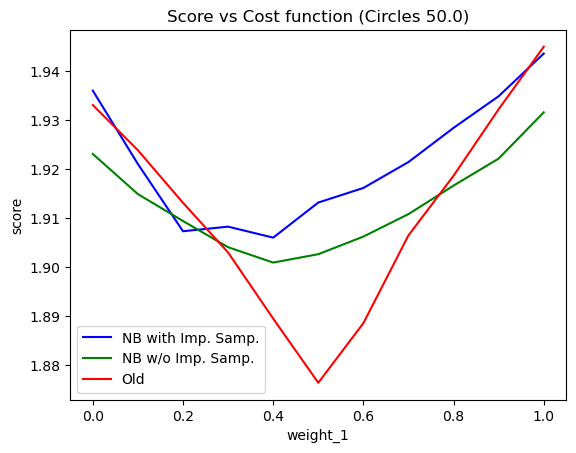

In [25]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, circles_50, color='blue')
plt.plot(wt_list, circles_50_non_imp, color='green')
plt.plot(wt_list, circles_75_old, color='red')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Circles 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB w/o Imp. Samp.', 'Old'])
plt.savefig('./results/circles_comparison_50_75.png')

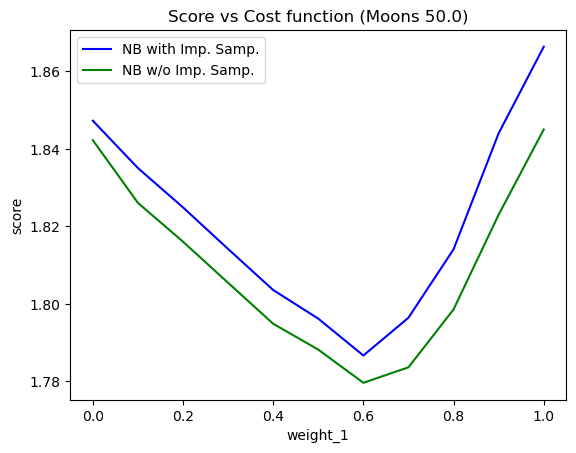

In [19]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, moons_50, color='blue')
plt.plot(wt_list, moons_50_non_imp, color='green')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Moons 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB w/o Imp. Samp.', 'Old'])
plt.savefig('./results/moons_comparison_50.png')

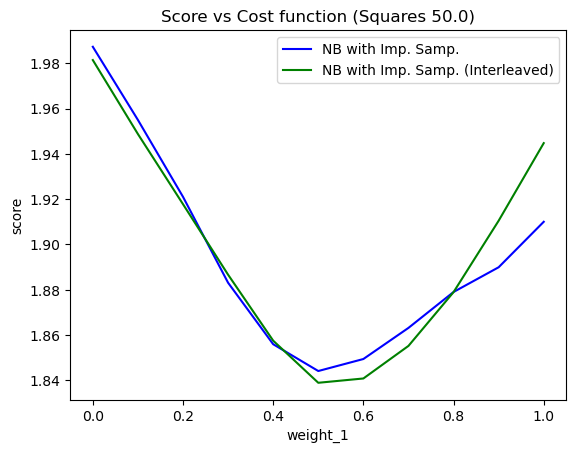

In [11]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, squares_50, color='blue')
plt.plot(wt_list, squares_50_2, color='green')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Squares 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB with Imp. Samp. (Interleaved)'])
plt.savefig('./results/squares_comparison_50_interleaved.png')

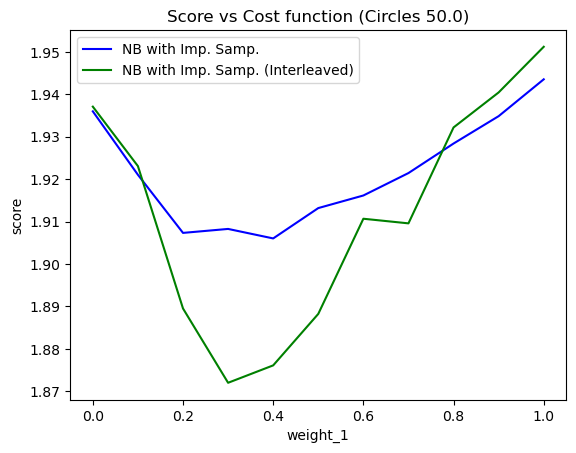

In [17]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, circles_50, color='blue')
plt.plot(wt_list, circles_50_2, color='green')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Circles 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB with Imp. Samp. (Interleaved)'])
plt.savefig('./results/circles_comparison_50_interleaved.png')

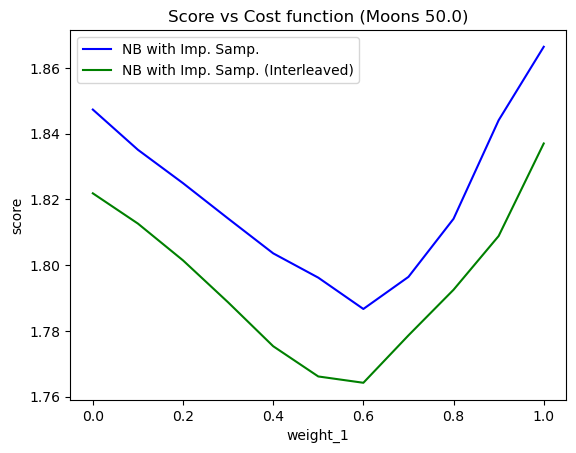

In [11]:
wt_list = np.arange(0.0, 1.1, 0.1)
plt.plot(wt_list, moons_50, color='blue')
plt.plot(wt_list, moons_50_2, color='green')
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function (Moons 50.0)')
plt.legend(['NB with Imp. Samp.', 'NB with Imp. Samp. (Interleaved)'])
plt.savefig('./results/moons_comparison_50_interleaved.png')